## Anomaly detection using an autoencoder
Trying to teach the actor I ran into a problem being the inconsistency of it's generated embeddings. It kept on spitting -1 tensors and being really dumb. To solve these, I introduce autoencoder anomaly detection. 
But aside from using just standard AE, we will also use the Wasserstein Distance as our 'resemblance' metric. Since that we just want to know how good the generated movie embeddings are, we will try to compare them to the real ones. But how do we do that? Just feed the known movies in the AutoEncoder and make it try to reconstruct them. Then feed the actor-generated embedding? Does the AE reconstruct it normally? If the output of the AE somewhat resembles the input, the film embedding seems to be 'normal'. It spits out nonsense that you don't even want to compare to the input, that is an anomaly and our actor (generator) learns something bad and not in the right direction. But what exactly does 'closely resembles' mean? Well, we just take the input and the output of the AE and calculate MSE between them. That way we get the score of how close they are. So we get the generated scores in the form of an array and that's cool. But it is not so valuable information. Assume we fed the AE some generated embedding and got an array of their MSEs such as [61, 12, 190, ...]. What do we do with that? That would be very cool if there was a way of comparing artificial embedds score distribution to the one generated by real embeddings. The only problem is that the size of the real disto is something around 27k and the generated embeds size may vary due to dynamic batch lengths and stuff like that. Luckily there is a way to look at 2 distributions and see how close they are. Well just use scipy Wassertein Distance function without getting deep into the Earth Mover's distance, Kantarovich-Rubenshtein duality and Farkases theorem. If you want to read about this exciting stuff here is [a good article](https://medium.com/@jonathan_hui/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490)


In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pickle
import json

from jupyterthemes import jtplot
jtplot.style(theme='monokai')

cuda = torch.device('cuda')
frame_size = 10

In [2]:
# https://drive.google.com/open?id=1kTyu05ZmtP2MA33J5hWdX8OyUYEDW4iI
movies = pickle.load(open('../../data/infos_pca128.pytorch', 'rb'))

In [3]:
for i in movies.keys():
    movies[i] = movies[i].to(cuda)

In [4]:
class AnomalyDetector(nn.Module):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.ae = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.ae(x)
    
    def rec_error(self, x):
        error = torch.sum((x - self.ae(x)) ** 2, 1)
        if x.size(1) != 1:
            return error.detach()
        return error.item()

In [5]:
data = torch.stack(list(movies.values())).to(cuda)
data = data[torch.randperm(data.size()[0])] # shuffle rows
data_test = data[-100:]
data = data[:-100]
n_epochs = 500
batch_size = 3048

model = AnomalyDetector().to(cuda)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=10e-5)
run_loss = []
test_loss = []
rec_loss = []
test_rec_loss = []

for epoch in tqdm(range(n_epochs)):
    for batch in data.split(batch_size):
        optimizer.zero_grad()
        batch = batch
        output = model(batch).float()
        loss = criterion(output, batch)
        test_loss.append(criterion(model(data_test).float(), data_test).item())
        rec_loss.append(model.rec_error(batch))
        test_rec_loss.append(model.rec_error(data_test))
        loss.backward()
        optimizer.step()
        run_loss.append(loss.item())

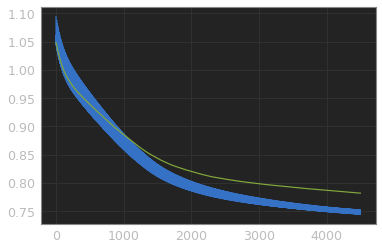

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(run_loss)
plt.plot(test_loss)
plt.show()

In [7]:
# real movies
def calc_art_score(x):
    return model.rec_error(x)  + (1 / x.var() * 5)

model.eval()
train_scores = model.rec_error(data).detach().cpu().numpy()
print(train_scores)

[136.20058  106.46437   90.54674  ...  81.781456  84.99221   54.943794]


### Now lets see what our autoencoder can do
Here you can see test scores reconstruction errors

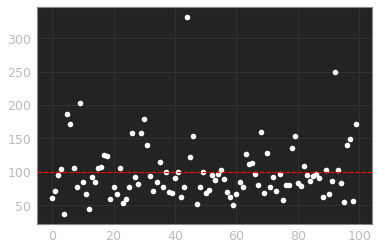

In [8]:
test_scores = model.rec_error(data_test)
scores = test_scores.detach().cpu().numpy()
plt.plot(scores, 'ow')
plt.axhline(y=np.mean(scores), label='mean', linestyle='--', color='red')
plt.show()

In [9]:
from scipy import stats
# test from train doesn't seem to be that far off!
stats.wasserstein_distance(train_scores, scores)

5.976378825041229

### This example shows randomly generated movies 
drawn from ~ Normal(0, 0.2):

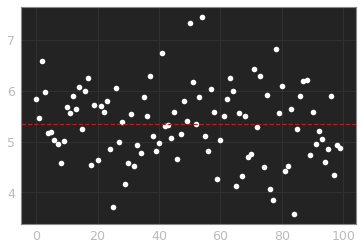

In [10]:
scores = model.rec_error(torch.tensor(np.random.normal(0, 0.2, [100, 128])).to(cuda).float())
scores = scores.detach().cpu().numpy()
plt.plot(scores, 'ow')s
plt.axhline(y=np.mean(scores), label='mean', linestyle='--', color='red')
plt.show()

In [11]:
stats.wasserstein_distance(train_scores, scores) # something doesnt quiet match here

90.73773298487863

### Here is that nasty -1 tensor
Normal distro was used to add some of variance

In [12]:
model.rec_error(torch.tensor([-1] * 128).unsqueeze(0).to(cuda).float())

tensor([180.8340], device='cuda:0')

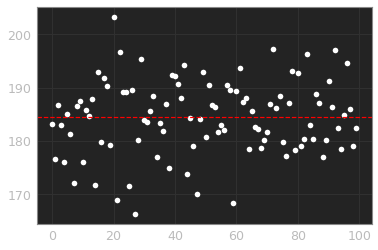

In [13]:
scores = model.rec_error(torch.tensor(np.random.normal(-1, 0.2, [100, 128])).to(cuda).float())
scores = scores.detach().cpu().numpy()
plt.plot(scores, 'ow')
plt.axhline(y=np.mean(scores), label='mean', linestyle='--', color='red')
plt.show()

In [14]:
stats.wasserstein_distance(train_scores, scores) # oh oh! Look at the number at the bottom!

89.29585920910601

## As you can see it works just fine!
The key thing here is to use the WS distance as the metric and not just look at the scores.
Anyway, as in any neural networks setup, our actor will be acting in batches. We will sample the generated films batch, feed it into the autoencoder, perform MSE with the ground truth and get the reconstruction score distribution. Then we will see how closely it resembles the real one using Wasserstein-Gromov metric.
### Anyway here are some cool KDE visualizations

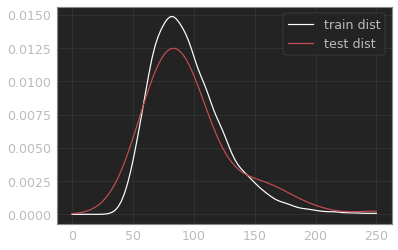

In [15]:
train_scores = model.rec_error(data).detach().cpu().numpy()
train_kernel = stats.gaussian_kde(train_scores)
test_scores = model.rec_error(data_test).detach().cpu().numpy()
test_kernel = stats.gaussian_kde(test_scores)
x = np.linspace(0,250, 100)
probs_train = train_kernel(x)
probs_test = test_kernel(x)
plt.plot(x, probs_train, '-w', label='train dist')
plt.plot(x, probs_test, '-r', label='test dist')
plt.legend()
plt.show()

In [17]:
import pandas as pd
print(pd.Series(train_scores).describe())
print(pd.Series(test_scores).describe())

count    27178.000000
mean        96.081581
std         33.990318
min         31.023582
25%         73.603914
50%         90.472656
75%        111.904184
max       1248.770020
dtype: float64
count    100.000000
mean      99.058098
std       43.513058
min       36.366425
25%       71.922089
50%       89.862183
75%      107.075008
max      332.133850
dtype: float64


In [22]:
torch.save(model.state_dict(), "../models/anomaly.pt")